In [68]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [33]:
# Load dataset
df = pd.read_csv("/content/card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [34]:
# Checking Null values
df.isnull().sum().sort_values(ascending=True)

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


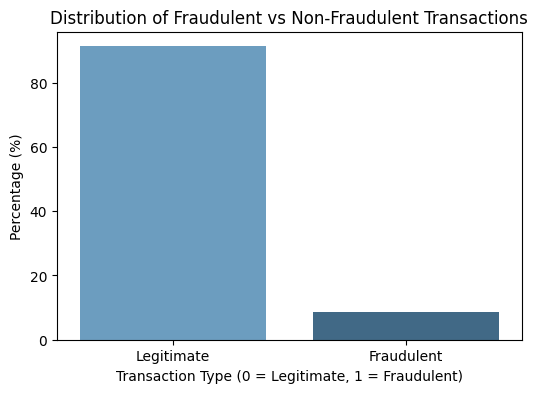

In [35]:
# Check the distribution of the dependent variable 'is_fraud'
fraud_percentage = df['fraud'].value_counts(normalize=True) * 100

# Plotting the distribution of 'is_fraud'
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_percentage.index, y=fraud_percentage.values, palette="Blues_d")
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("Transaction Type (0 = Legitimate, 1 = Fraudulent)")
plt.ylabel("Percentage (%)")
plt.xticks([0, 1], ["Legitimate", "Fraudulent"], rotation=0)
plt.show()

<Figure size 1000x600 with 0 Axes>

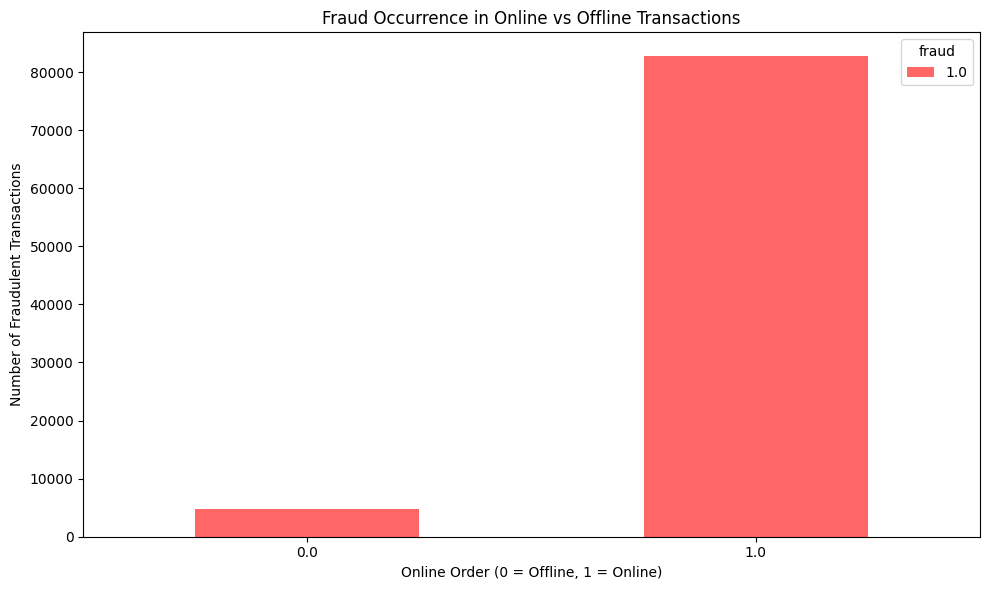

In [79]:
# Filter only fraudulent transactions
online_offline_fraud = df[df['fraud'] == 1].groupby(['online_order', 'fraud']).size().unstack(fill_value=0)

# Plotting fraud occurrence in online vs offline transactions
plt.figure(figsize=(10, 6))
online_offline_fraud.plot(kind='bar', color='#FF6666', figsize=(10,6))

# Adding labels and title
plt.title("Fraud Occurrence in Online vs Offline Transactions")
plt.xlabel("Online Order (0 = Offline, 1 = Online)")
plt.ylabel("Number of Fraudulent Transactions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


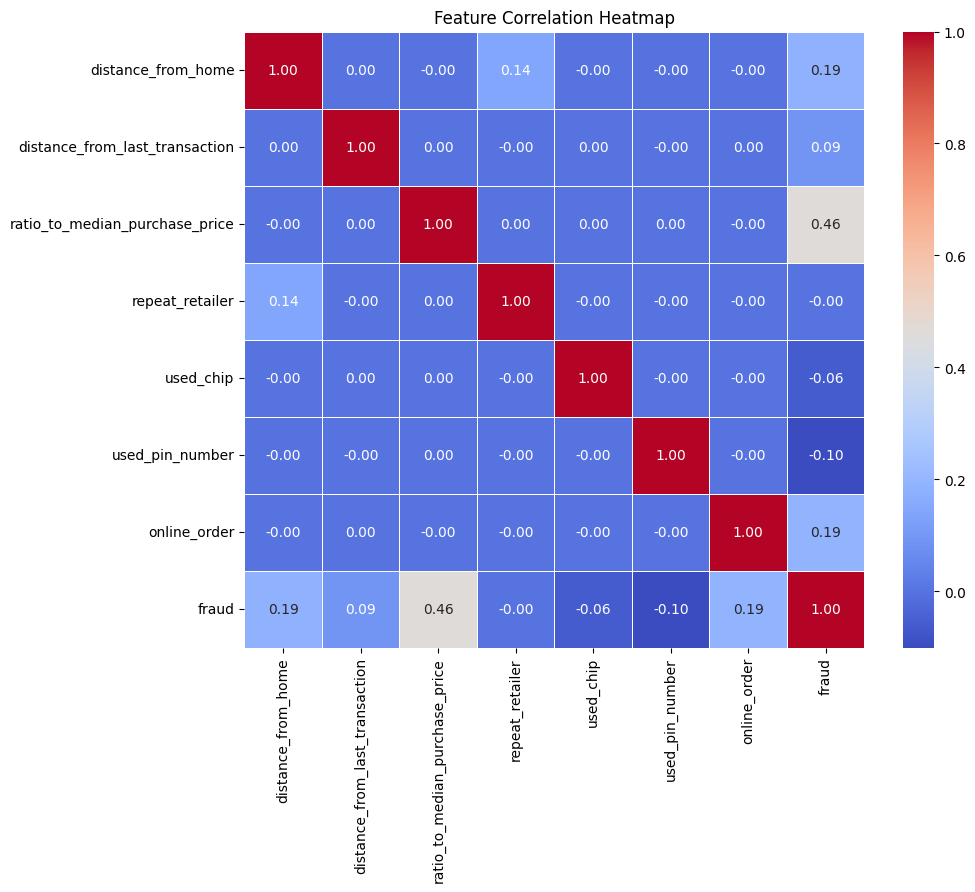

In [36]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and display
plt.title('Feature Correlation Heatmap')
plt.show()

In [37]:
# Dropping column repeat_retailer(0 corelation with dependent and others)
df.drop('repeat_retailer', axis=1, inplace=True)

In [44]:
# Define numerical columns (all columns except the categorical ones)
num_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']


col_trans =ColumnTransformer(transformers=[('Standard',StandardScaler(),num_cols)],remainder='passthrough')
                                                                    # remainder = passthrough means that remaining undefined cols will pass through as it is


In [50]:
# Define feature columns and target column
X = df.drop(columns='fraud')  # Features
y = df['fraud']  # Target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
# Column transforming
X_tr_trans = col_trans.fit_transform(X_train)
X_te_trans = col_trans.transform(X_test)


In [54]:
X_tr_trans[0]

array([ 0.14717014, -0.1811908 , -0.58818513,  1.        ,  0.        ,
        1.        ])

In [56]:
# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_tr_trans, y_train)


In [57]:
# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [59]:
# Make predictions on the test set
y_pred = log_reg.predict(X_te_trans)


Accuracy: 0.9339
Precision: 0.5728
Recall: 0.9525
F1-Score: 0.7154
ROC-AUC: 0.9423
Confusion Matrix: 
[[170165  12392]
 [   829  16614]]


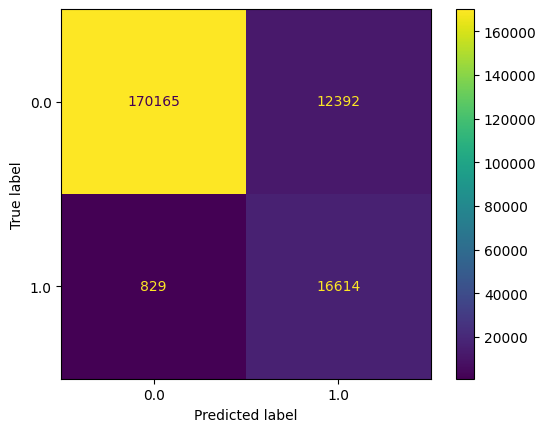

In [65]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=log_reg.classes_).plot())
plt.show()

In [67]:
'''Analysis of Metrics:
Accuracy (93.39%) is high, but accuracy alone can be misleading in an imbalanced dataset.
Precision (57.28%) means that out of all predicted fraud cases, only 57.28% were actually fraud. This indicates a relatively high false positive rate.
Recall (95.25%) is excellent, meaning the model is catching most fraudulent transactions.
F1-Score (71.54%) balances precision and recall but could be improved.
ROC-AUC (94.23%) suggests that the model does a good job distinguishing fraud from non-fraud.
Confusion Matrix Breakdown:
Predicted Non-Fraud	Predicted Fraud
Actual Non-Fraud	170,165 (True Negative)	12,392 (False Positive)
Actual Fraud	829 (False Negative)	16,614 (True Positive)
False Positives (12,392 cases) → Transactions incorrectly classified as fraud. This might cause inconvenience to real customers.
False Negatives (829 cases) → Actual fraud cases that were missed. Reducing this is critical for fraud detection.'''

'Analysis of Metrics:\nAccuracy (93.39%) is high, but accuracy alone can be misleading in an imbalanced dataset.\nPrecision (57.28%) means that out of all predicted fraud cases, only 57.28% were actually fraud. This indicates a relatively high false positive rate.\nRecall (95.25%) is excellent, meaning the model is catching most fraudulent transactions.\nF1-Score (71.54%) balances precision and recall but could be improved.\nROC-AUC (94.23%) suggests that the model does a good job distinguishing fraud from non-fraud.\nConfusion Matrix Breakdown:\nPredicted Non-Fraud\tPredicted Fraud\nActual Non-Fraud\t170,165 (True Negative)\t12,392 (False Positive)\nActual Fraud\t829 (False Negative)\t16,614 (True Positive)\nFalse Positives (12,392 cases) → Transactions incorrectly classified as fraud. This might cause inconvenience to real customers.\nFalse Negatives (829 cases) → Actual fraud cases that were missed. Reducing this is critical for fraud detection.'

In [69]:
# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Solvers compatible with l1 and l2
}

# GridSearchCV with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_tr_trans, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [71]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Accuracy: 0.2329
Precision: 0.1021
Recall: 1.0000
F1-Score: 0.1853
ROC-AUC: 0.5798
Confusion Matrix: 
[[ 29137 153420]
 [     0  17443]]


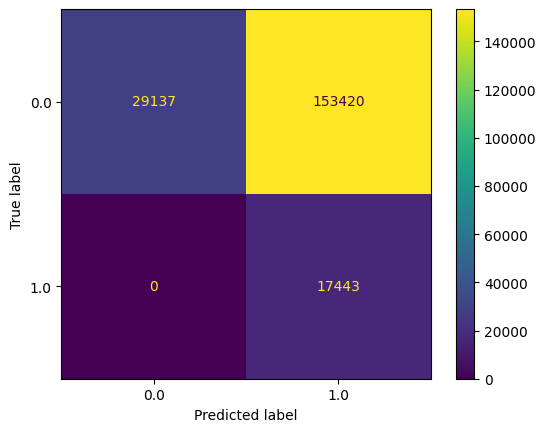

In [72]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=log_reg.classes_).plot())
plt.show()

In [74]:
# creating pickle file of voting classifier
with open('/content/logistic_reg.pkl', 'wb') as model_file:
    pickle.dump(log_reg, model_file)

# creating pickle file of
with open('/content/column_transformer.pkl', 'wb') as tr_file:
    pickle.dump(col_trans, tr_file)
